**Downloading and Extracting Dataset**

In [ ]:
import gdown
import zipfile
import os

# old one = 1AjmFI_AGN2UGN2bKOmCMMNzwTsfzNKd3
# new one = 1Jhl_i6ostKOM22CNK3Qx8y82v6NDum_n

file_id = "1Jhl_i6ostKOM22CNK3Qx8y82v6NDum_n"
# Direct download URL format
download_url = f"https://drive.google.com/uc?id={file_id}"

# Output ZIP file name
zip_path = "track_images_dataset.zip"

# Download using fuzzy to avoid format issues
gdown.download(download_url, zip_path, quiet=False)

# Extract the ZIP file
extract_path = "track_images_dataset"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

# List extracted files
print("Extracted files:")
print(os.listdir(extract_path))

Downloading...
From (original): https://drive.google.com/uc?id=1Jhl_i6ostKOM22CNK3Qx8y82v6NDum_n
From (redirected): https://drive.google.com/uc?id=1Jhl_i6ostKOM22CNK3Qx8y82v6NDum_n&confirm=t&uuid=d93fc9d1-f485-4f86-bd45-a5294a8f3e86
To: /content/track_images_dataset.zip
100%|██████████| 68.1M/68.1M [00:02<00:00, 23.4MB/s]


Extracted files:
['tryout_training_images']


**Opening an image from the dataset**

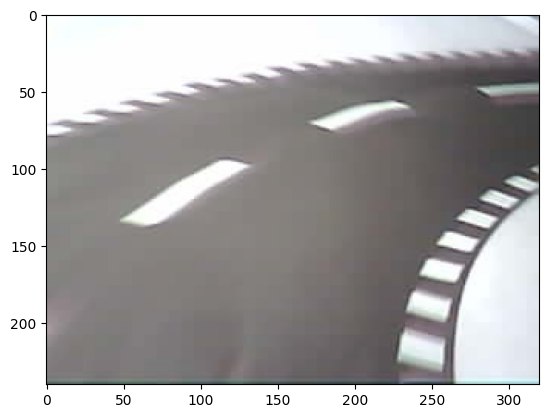

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Path to the image
image_path = "/content/track_images_dataset/tryout_training_images/forward_images/1009_0_07-01-2025_18-37-33-682.jpg"

# Load the image (assuming it's in standard RGB format)
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert OpenCV's BGR format to RGB

# Display the image
plt.imshow(image)
plt.axis("on")  # Hide axes
plt.show()


**Visualizing and Balancing the Dataset**

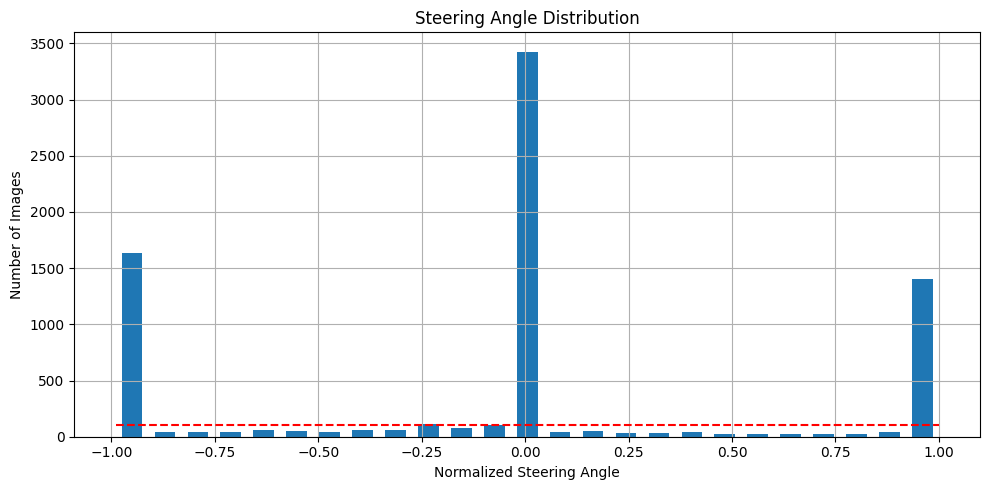

Removed: 6183
Remaining: 1327


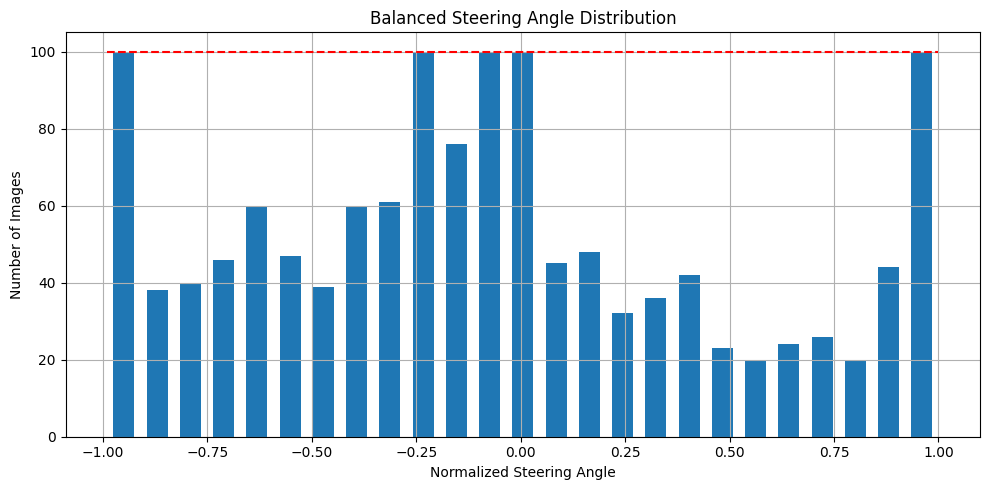

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import random
import albumentations as A
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Conv2D, Flatten, Dense

# --- Parameters and paths ---
base_path = r"/content/track_images_dataset/tryout_training_images"
folders = ["forward_images", "backward_images"]
num_bins = 25
samples_per_bin = 100
BATCH_SIZE = 64
EPOCHS = 15
IMG_HEIGHT, IMG_WIDTH = 66, 200

# --- Step 1: Collect filenames and steering values ---
image_paths = []
steerings = []

for folder in folders:
    full_path = os.path.join(base_path, folder)
    for filename in os.listdir(full_path):
        if filename.lower().endswith('.jpg'):
            parts = filename.split('_')
            if len(parts) > 1:
                try:
                    angle = float(parts[1]) / 100  # normalize to [-1, 1]
                    steerings.append(angle)
                    image_paths.append(os.path.join(full_path, filename))
                except ValueError:
                    continue

steerings = np.array(steerings)
image_paths = np.array(image_paths)

# --- Step 2: Balance the dataset ---
hist, bins = np.histogram(steerings, num_bins)
center = (bins[:-1] + bins[1:]) * 0.5

# Plot balanced histogram
hist, _ = np.histogram(steerings, num_bins)
plt.figure(figsize=(10, 5))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(steerings), np.max(steerings)), (samples_per_bin, samples_per_bin), 'r--')
plt.title("Steering Angle Distribution")
plt.xlabel("Normalized Steering Angle")
plt.ylabel("Number of Images")
plt.grid(True)
plt.tight_layout()
plt.show()

remove_list = []
for j in range(num_bins):
    bin_indices = [i for i in range(len(steerings)) if steerings[i] >= bins[j] and steerings[i] <= bins[j+1]]
    bin_indices = shuffle(bin_indices)
    if len(bin_indices) > samples_per_bin:
        remove_list.extend(bin_indices[samples_per_bin:])

print('Removed:', len(remove_list))
steerings = np.delete(steerings, remove_list)
image_paths = np.delete(image_paths, remove_list)
print('Remaining:', len(steerings))

# Plot balanced histogram
hist, _ = np.histogram(steerings, num_bins)
plt.figure(figsize=(10, 5))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(steerings), np.max(steerings)), (samples_per_bin, samples_per_bin), 'r--')
plt.title("Balanced Steering Angle Distribution")
plt.xlabel("Normalized Steering Angle")
plt.ylabel("Number of Images")
plt.grid(True)
plt.tight_layout()
plt.show()

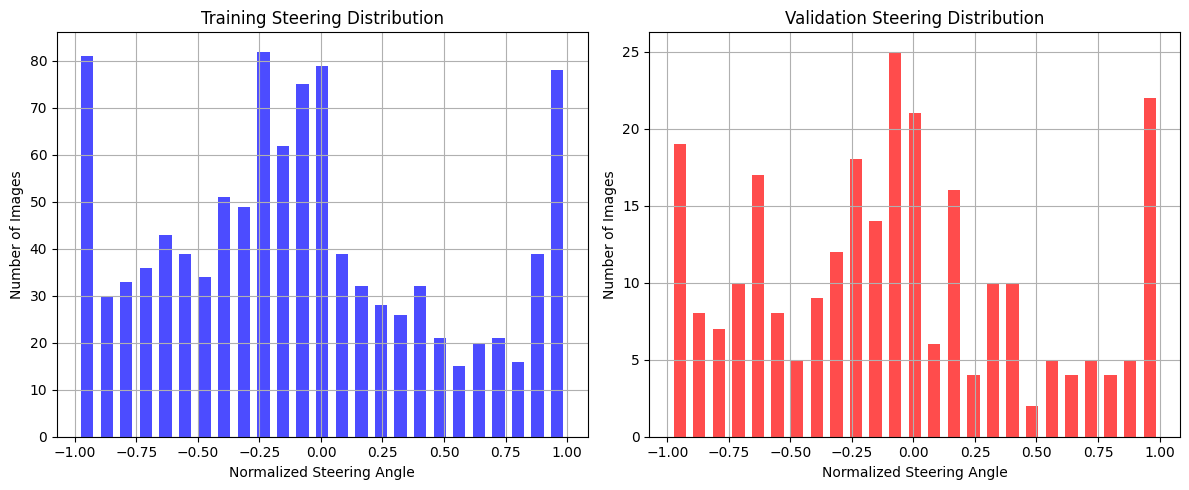

Training samples: 1061, Validation samples: 266


In [ ]:
# --- Step 3: Visualize distribution before splitting ---
# Split first to get distributions
x_train, x_valid, y_train, y_valid = train_test_split(
    image_paths, steerings, test_size=0.2, random_state=42
)

# Plot histograms
train_hist, train_bins = np.histogram(y_train, num_bins)
valid_hist, valid_bins = np.histogram(y_valid, num_bins)
train_center = (train_bins[:-1] + train_bins[1:]) * 0.5
valid_center = (valid_bins[:-1] + valid_bins[1:]) * 0.5

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(train_center, train_hist, width=0.05, color='blue', alpha=0.7)
plt.title("Training Steering Distribution")
plt.xlabel("Normalized Steering Angle")
plt.ylabel("Number of Images")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar(valid_center, valid_hist, width=0.05, color='red', alpha=0.7)
plt.title("Validation Steering Distribution")
plt.xlabel("Normalized Steering Angle")
plt.ylabel("Number of Images")
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Training samples: {len(x_train)}, Validation samples: {len(x_valid)}")

In [ ]:
# --- Step 4: Data augmentation functions ---
def zoom(image):
    return A.Affine(scale=(1.0, 1.3), p=1.0)(image=image)['image']

def pan(image):
    return A.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, p=1.0)(image=image)['image']

# def random_brightness(image):
#     return A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0, p=1.0)(image=image)['image']

def random_flip(image, steering_angle):
    if random.random() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle

def random_augment(image_path, steering_angle):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if random.random() < 0.5:
        image = zoom(image)
    if random.random() < 0.5:
        image = pan(image)
    # if random.random() < 0.5:
    #     image = random_brightness(image)
    image, steering_angle = random_flip(image, steering_angle)
    return image, steering_angle

In [ ]:
# --- Step 5: Preprocess images  ---
def preprocess(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    image = cv2.GaussianBlur(image, (3, 3), 0)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = image / 255.0
    return image

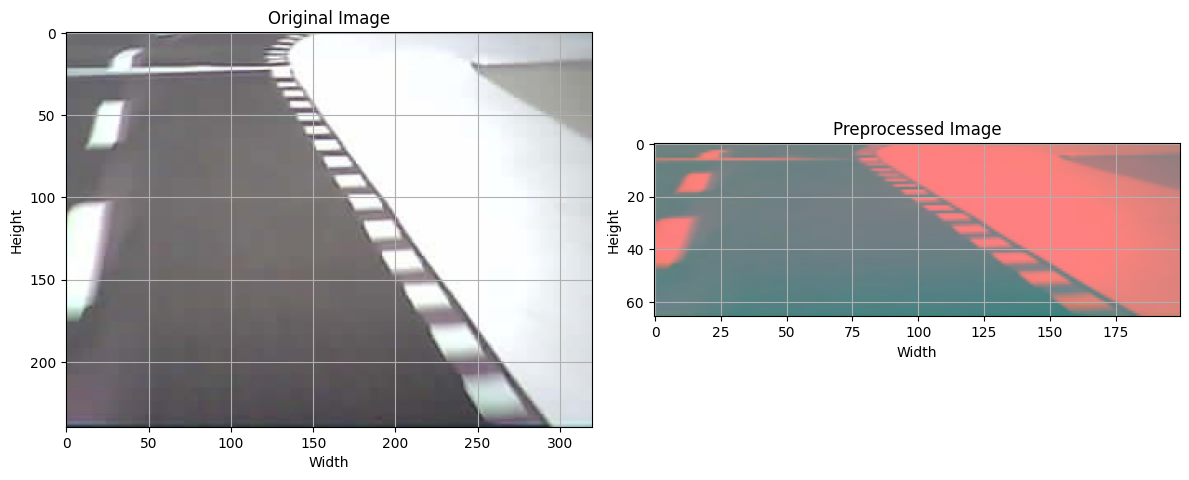

In [ ]:
import random
import cv2
import matplotlib.pyplot as plt

# Pick a random image from the dataset
rand_index = random.randint(0, len(image_paths) - 1)
original_img = cv2.imread(image_paths[rand_index])
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Preprocess the image
processed_img = preprocess(original_img)

# Plot side-by-side comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.xlabel("Width")
plt.ylabel("Height")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.imshow(processed_img)
plt.title("Preprocessed Image")
plt.xlabel("Width")
plt.ylabel("Height")
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# --- Step 6: Batch generator ---
def batch_generator(image_paths, steerings, batch_size, is_training):
    while True:
        batch_images, batch_steering = [], []
        for _ in range(batch_size):
            idx = random.randint(0, len(image_paths) - 1)
            if is_training:
                image, steering = random_augment(image_paths[idx], steerings[idx])
            else:
                image = cv2.imread(image_paths[idx])
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                steering = steerings[idx]
            batch_images.append(preprocess(image))
            batch_steering.append(steering)
        yield np.array(batch_images), np.array(batch_steering)

from keras.layers import Input

In [ ]:
# --- Step 7: Nvidia model ---
def nvidia_model():
    model = Sequential([
        InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        Conv2D(24, (5, 5), strides=(2, 2), activation='relu'),
        Conv2D(36, (5, 5), strides=(2, 2), activation='relu'),
        Conv2D(48, (5, 5), strides=(2, 2), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(100, activation='relu'),
        Dense(50, activation='relu'),
        Dense(10, activation='relu'),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))
    return model

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - loss: 0.3202 - val_loss: 0.2301
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.2318 - val_loss: 0.1662
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - loss: 0.1615 - val_loss: 0.1373
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - loss: 0.1461 - val_loss: 0.1626
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - loss: 0.1541 - val_loss: 0.1280
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - loss: 0.1465 - val_loss: 0.1315
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - loss: 0.1651 - val_loss: 0.1455
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - loss: 0.1485 - val_loss: 0.1320
Epoch 9/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - loss: 0.1336 - val_loss: 0.1138
Epoch 10/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - loss: 0.1436 - val_loss: 0.1142
Epoch 11/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.1377 - val_loss: 0.1251
Epoch 12/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step

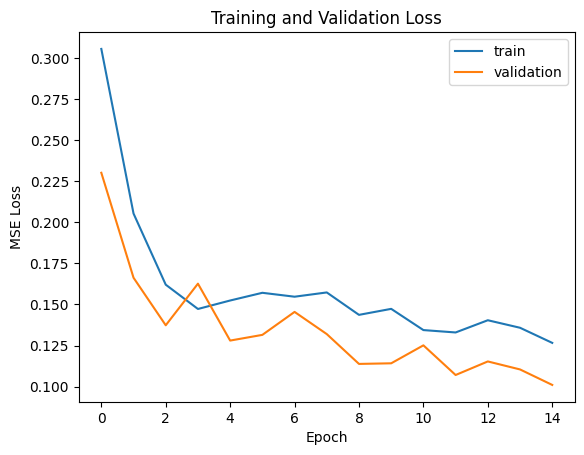

In [ ]:
# --- Step 8: Train the model ---
model = nvidia_model()
history = model.fit(
    batch_generator(x_train, y_train, BATCH_SIZE, True),
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=batch_generator(x_valid, y_valid, BATCH_SIZE, False),
    validation_steps=len(x_valid) // BATCH_SIZE,
    verbose=1
)

# --- Step 9: Plot loss ---
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# # --- Step 10: Save the model ---
model.save("new_non_golay_model_2.h5", save_format="h5", include_optimizer=False)

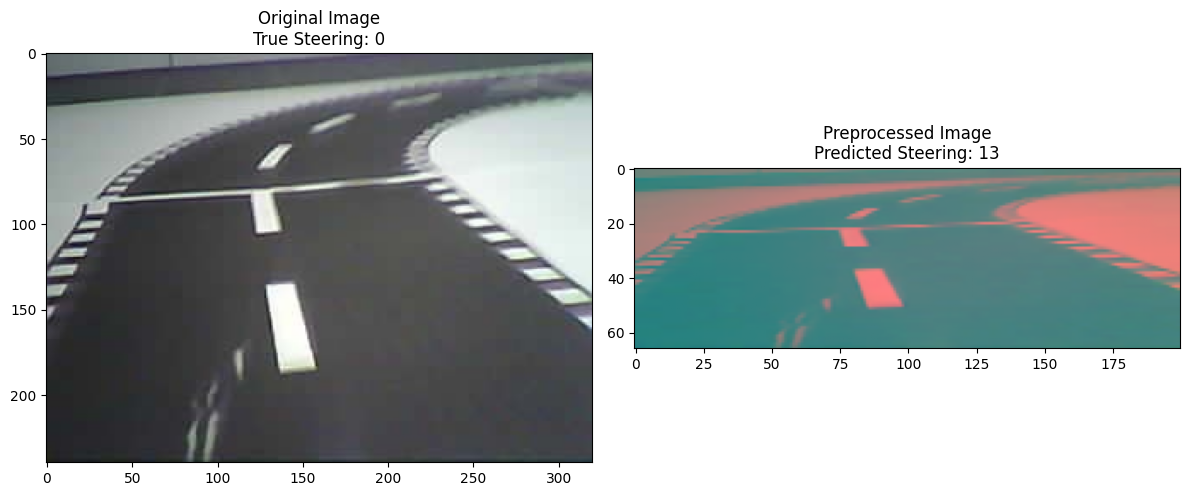

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# --- Parameters ---
IMG_HEIGHT, IMG_WIDTH = 66, 200

# --- Load trained model ---
model = load_model("golay_model_2.h5", compile=False)

# --- Preprocess function (same as training) ---
def preprocess(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    image = cv2.GaussianBlur(image, (3, 3), 0)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = image / 255.0
    return image

# --- Image path (from your dataset) ---
image_path = "/content/track_images_dataset/12 Laps perfected new/backward_images/1213_0_06-02-2025_13-05-51-144.jpg"
# "C:\VS Code Codes\Self Driving Car\12 Laps perfected new\forward_images\3063_0_06-02-2025_13-03-50-644.jpg"

# --- Extract steering angle from filename (normalized) ---
filename = image_path.split("/")[-1]
steering_true = int(filename.split("_")[1])  # Already in 0–100 range, original label

# --- Load and preprocess ---
original_img = cv2.imread(image_path)
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
preprocessed_img = preprocess(original_img_rgb)
preprocessed_input = np.expand_dims(preprocessed_img, axis=0)

# --- Predict with model ---
predicted_angle = model.predict(preprocessed_input, verbose=0)[0][0]  # Normalized
predicted_angle_int = round(predicted_angle * 100)

# --- Show side-by-side ---
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(original_img_rgb)
plt.title(f"Original Image\nTrue Steering: {steering_true}")
plt.axis("on")

# Preprocessed image
plt.subplot(1, 2, 2)
plt.imshow(preprocessed_img)
plt.title(f"Preprocessed Image\nPredicted Steering: {predicted_angle_int}")
plt.axis("on")

plt.tight_layout()
plt.show()


In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# --- CONFIGURATION ---
image_folder = r"/content/track_images_dataset/12 Laps perfected new/backward_images"
output_video = r"/content/track_images_dataset/12 Laps perfected new/golay1_backward_angle_comparison_video.avi"
model_path = r"/content/golay_model_2.h5"

IMG_HEIGHT, IMG_WIDTH = 66, 200

# --- Load Model ---
model = load_model(model_path, compile=False)

# --- Preprocess function (same as training) ---
def preprocess(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    image = cv2.GaussianBlur(image, (3, 3), 0)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = image / 255.0
    return image

# --- Get images ---
images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
images.sort()

# --- Video writer setup ---
first_image_path = os.path.join(image_folder, images[0])
frame = cv2.imread(first_image_path)
height, width, _ = frame.shape

fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = 24.0
video = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

# --- Font settings ---
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_color = (0, 255, 0)
thickness = 2

# --- Process and write each frame ---
for image_name in images:
    image_path = os.path.join(image_folder, image_name)
    frame = cv2.imread(image_path)

    # Get ground truth from filename
    parts = image_name.split("_")
    if len(parts) >= 2:
        true_angle = int(parts[1])
    else:
        true_angle = -999  # Unknown

    # Preprocess image for model
    preprocessed = preprocess(frame)
    input_img = np.expand_dims(preprocessed, axis=0)

    # Predict
    predicted = model.predict(input_img, verbose=0)[0][0]  # Normalized
    predicted_angle = round(predicted * 100)

    # Compose text
    true_text = f"True Angle: {true_angle}"
    pred_text = f"Predicted: {predicted_angle}"

    # Position text
    (tw1, th1), _ = cv2.getTextSize(true_text, font, font_scale, thickness)
    (tw2, th2), _ = cv2.getTextSize(pred_text, font, font_scale, thickness)
    pos1 = (10, 30)
    pos2 = (10, 60)

    # Overlay text
    cv2.putText(frame, true_text, pos1, font, font_scale, (0, 255, 255), thickness)
    cv2.putText(frame, pred_text, pos2, font, font_scale, (255, 0, 0), thickness)

    # Write to video
    video.write(frame)

video.release()
print(f"✅ Video saved to: {output_video}")


✅ Video saved to: /content/track_images_dataset/12 Laps perfected new/golay1_backward_angle_comparison_video.avi
